In [25]:
from collections import Counter
import pandas as pd
import numpy as np

from nltk.corpus import opinion_lexicon
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

import altair as alt
# Optional in Jupyter Notebook: requires an up-to-date vega nbextension.
alt.renderers.enable('mimetype')

import random

In [5]:
df = pd.read_csv("data/small_verified_corpus.tsv", sep="\t")

ratings = list(df["ratings"])
reviews = list(df["reviewText"])

In [6]:
len(ratings)

4500

In [7]:
len(reviews)

4500

In [35]:
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

In [36]:
# Returns a score between -1 to 1
def score_sentence(sentence, pos_words, neg_words):
    words = [e.lower() for e in sentence if e.isalnum()]
    total = len(words)
    pos = len([e for e in sentence if e in pos_words])
    neg = len([e for e in sentence if e in neg_words])
    if total > 0:
        return (pos - neg) / total
    else:
        return 0

In [37]:
# Returns a score between -1 to 1
def score_review(review):
    sentiment_scores = []
    sents = sent_tokenize(review)
    for sent in sents:
        wds = word_tokenize(sent)
        sent_scores = score_sentence(wds, positive_words, negative_words)
        sentiment_scores.append(sent_scores)
    return sum(sentiment_scores) / len(sentiment_scores)

## Calcuate the sentiment based on the workds in the reviews

In [38]:
review_sentiments = [score_review(review) for review in reviews]

In [39]:
small_corpus_df = pd.DataFrame(
    {
        "rating": ratings,
        "review": reviews,
        "sentiment_by_review_words": review_sentiments,
    }
)

### Analysis

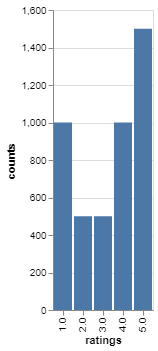

In [40]:
# let's see the distributions

# the distribution of review scores
rating_counts = Counter(ratings)
data1 = pd.DataFrame(
    {
        "ratings": [str(e) for e in list(rating_counts.keys())],
        "counts": list(rating_counts.values()),
    }
)

alt.Chart(data1).mark_bar().encode(x="ratings", y="counts")

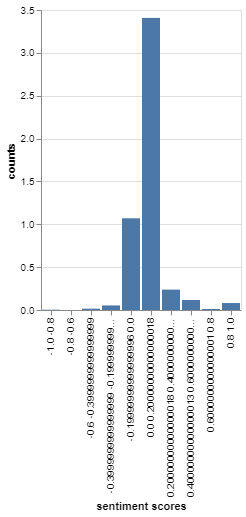

In [41]:
# the distribution of sentiment scores
hist, bin_edges = np.histogram(review_sentiments, density=True)
labels = list(zip(bin_edges, bin_edges[1:]))
labels = [(str(e[0]), str(e[1])) for e in labels]
labels = [" ".join(e) for e in labels]


data2 = pd.DataFrame({"sentiment scores": labels, "counts": hist})

chart2 = (
    alt.Chart(data2)
    .mark_bar()
    .encode(x=alt.X("sentiment scores", sort=labels), y="counts")
)
chart2

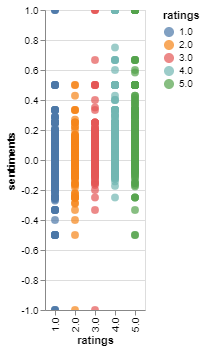

In [42]:
# is there any relationship btw review scores and sentiments?
source = pd.DataFrame(
    {"ratings": [str(e) for e in ratings], "sentiments": review_sentiments}
)


chart4 = (
    alt.Chart(source)
    .mark_circle(size=60)
    .encode(
        x="ratings", y="sentiments", color="ratings", tooltip=["ratings", "sentiments"]
    )
    .interactive()
)
chart4

In [43]:
###############################################################################
#####                             Correlation                             #####
###############################################################################
# test correlation
from scipy.stats import pearsonr, spearmanr

corr1, _ = pearsonr(ratings, review_sentiments)
print(corr1)
# 0.5484025893803234

# Spearman rank correlation says there's weak correlation btw review score
# and sentiment
scor1, _ = spearmanr(ratings, review_sentiments)

print(scor1)
# 0.6248595756447616

0.31007772918218
0.41352044323543324


## investigation

In [44]:
###############################################################################
######                          Let's see the data                       ######
###############################################################################
review_good_sentiment_bad = []
review_bad_sentiment_good = []
for i in range(len(reviews)):
    sc = ratings[i]
    rs = review_sentiments[i]
    # ss = summary_sentiments[i]
    t = reviews[i]
    if sc == 5 and rs < -0.2:
        review_good_sentiment_bad.append(t)
    if sc == 1 and rs > 0.3:
        review_bad_sentiment_good.append(t)

In [45]:
review_good_sentiment_bad[:20]

['No issues.  Great game',
 'No issues...',
 'No issues.',
 'exelent tem , no complains.',
 'Fun and challenging!',
 'Excellent, without any mishap']

In [46]:
review_bad_sentiment_good[:20]

["Sound didn't work",
 'Does not work.',
 "Didn't work, return",
 'not great!',
 "doesn't work",
 "Return/didn't work",
 'not that good',
 "Doesn't work",
 "didn't work",
 'doesnt work',
 "Controller didn't work properly.",
 'super',
 "Didn't work",
 'did not work',
 'good',
 "Games aren't fun.",
 'Never worked once']

## handling negation

In [48]:
from nltk.sentiment.util import mark_negation

t = "I received these on time and no problems. No damages battlfield never fails"
print(mark_negation(t.split()))

['I', 'received', 'these', 'on', 'time', 'and', 'no', 'problems._NEG', 'No_NEG', 'damages_NEG', 'battlfield_NEG', 'never_NEG', 'fails_NEG']


In [47]:


## Lets enhance positive words and negative words by appending negation the negative words
positive_words_with_negation = positive_words.union({wd + "_NEG" for wd in negative_words})
negative_words_with_negation = negative_words.union({wd + "_NEG" for wd in positive_words})

In [55]:
def score_review_with_negation(review):
    sentiment_scores = []
    sents = sent_tokenize(review)
    for sent in sents:
        wds = word_tokenize(sent)
        wds = mark_negation(wds)
        sent_scores = score_sentence(wds, positive_words_with_negation, negative_words_with_negation)
        sentiment_scores.append(sent_scores)
    return sum(sentiment_scores) / len(sentiment_scores)

In [56]:
review_sentiments_with_negation = [score_review_with_negation(review) for review in reviews]

In [57]:
sentiment_with_negation_df = pd.DataFrame(
    {"rating": ratings, "review": reviews, "review sentiment": review_sentiments_with_negation,}
)


In [58]:
scor1, _ = spearmanr(ratings, review_sentiments_with_negation)
print(scor1)

0.4320049839385447


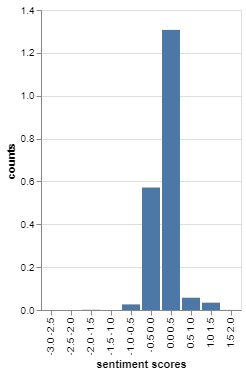

In [63]:
hist, bin_edges = np.histogram(review_sentiments_with_negation, density=True)
labels = list(zip(bin_edges, bin_edges[1:]))
labels = [(str(e[0]), str(e[1])) for e in labels]
labels = [" ".join(e) for e in labels]


data2 = pd.DataFrame({"sentiment scores": labels, "counts": hist})

chart2 = (
    alt.Chart(data2)
    .mark_bar()
    .encode(x=alt.X("sentiment scores", sort=labels), y="counts")
)
chart2

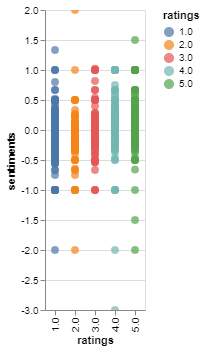

In [64]:
# is there any relationship btw review scores and sentiments?
source = pd.DataFrame(
    {"ratings": [str(e) for e in ratings], "sentiments": review_sentiments_with_negation}
)

chart4 = (
    alt.Chart(source)
    .mark_circle(size=60)
    .encode(
        x="ratings", y="sentiments", color="ratings", tooltip=["ratings", "sentiments"]
    )
    .interactive()
)
chart4

## investigation...

In [60]:
review_good_sentiment_bad = []
review_bad_sentiment_good = []
for i in range(len(reviews)):
    sc = ratings[i]
    rs = review_sentiments_with_negation[i]
    # ss = summary_sentiments[i]
    t = reviews[i]
    if sc == 5 and rs < -0.2:
        review_good_sentiment_bad.append(t)
    if sc == 1 and rs > 0.3:
        review_bad_sentiment_good.append(t)

review_good_sentiment_bad[:5]

['No issues.  Great game',
 'If you have little kids, (not older, definately not teenagers) this game is very good for keeping the youngins interested, happy and is actually quite fun to play for those that are really too young to play playstation and xbox consoles. I good deal even at this price range to keep their attention for hours at a time.',
 'No issues...',
 "Bought for my adult son who is a South Park and video game fan. He can't stop playing it and has friends over who also have a great time playing it. No complaints from any of them. He couldn't be happier.",
 "Who doesn't love WindWaker! I myself am not a huge fan of Nintendo's creative choice to add a ton of bloom to the game. But I suppose that is more of a knock towards the Wii U's lack of horsepower than the game itself. Outside of that it is wonderful to have the game that myself and my family spent so many hours playing in HD!"]

In [61]:
review_bad_sentiment_good[:5]

["Game will not load it always crashes at the menu screen idk why but it's the only game over ever had to do this.",
 "the game diden't play at all very disapointed feel lied to about condition waste of money so unhappy with this.",
 'this game was not bad to start 0ff with but when i tried to play it again it my monitor had a white line on the bottom oif the screen which covered up the list of hidden objects i was to look for and so this is why it will only get one star from me  very disappointed by this',
 'the game cheats i shot a guy 4 times running for the alarm and he did  not die poor game design stealth sections do not work enemy spots all the tme run for alarm when shoot an enemy they yell to ruin your stealth thats cheating  you shoot the enemy and they cheat and do not die pc games do not belong on ps2 this game is garbage',
 'Not recommended, not provide solutions to the concerns of a simple traking number that was canceled and have the obligcacin to provide it to the clien

## apply machine learning technique